In [ ]:
# This code is retrieved from Michel's notebook
# READ: https://hatchjs.com/graph-from-place-osmnx/

In [2]:
import geopandas as gpd # for geospatial data handling
import pandas as pd
import osmnx as ox # for handling data from OpenStreetMap (osm) with the help of networkX (nx)
import contextily as cx # for plotting
import matplotlib.pyplot as plt # for plotting
from pyproj import CRS # for more advanced CRS modifications and transformations
from shapely.geometry import Polygon
import numpy as np
import pandana as pdna
import os
from tqdm import tqdm

In [3]:
# RUN ONLY ONCE TO SAVE THE GRAPHS - ALREADY DONE

# walking_graphs = {}

# # specify parameters for the analysis
# walk_time = 15  # max walking horizon in minutes
# walk_speed = 5  # km per hour
# walk_time_sec = walk_time * 60 # We need the time in seconds to match how travel time is calculated in OSMnx

# # Loop through the neighborhoods
# for neighborhood in tqdm(neighbourhoods):
#     # Create a graph for the current neighborhood
#     G_walk_neighborhood = ox.graph_from_place(neighborhood, network_type='walk') # type of transportation is set here

#     for u, v, data in G_walk_neighborhood.edges(data=True):
#         data['speed_kph'] = walk_speed
#     G_walk_neighborhood = ox.add_edge_travel_times(G_walk_neighborhood) # this computes the travel time in seconds based on the 'speed_kph' column

# # caro path
#     # ox.save_graphml(G_walk_neighborhood, f"/Users/caro/Desktop/SPRING24/GDS/PROJECT/graphs/G_walk_{neighborhood}.graphml") # save graph per neighbourhood
# # michel path
#     ox.save_graphml(G_walk_neighborhood, f"../graphs/G_walk_{neighborhood}.graphml") # save graph per neighbourhood
#     # Store the graph in the dictionary using the neighborhood name as the key
#     walking_graphs[neighborhood] = G_walk_neighborhood

In [4]:
place = 'Montreal, Canada'
list_of_amenities = ['restaurant', 'cafe', 'pharmacy', 'hospital', 'parking']
tags = {'amenity': list_of_amenities}

walk_time = 15  # max walking horizon in minutes
walk_speed = 5  # km per hour
walk_time_sec = walk_time * 60 # We need the time in seconds to match how travel time is calculated in OSMnx

bike_time = 15  # max walking horizon in minutes
bike_speed = 15  # km per hour
bike_time_sec = bike_time * 60 # We need the time in seconds to match how travel time is calculated in OSMnx

drive_time = 15
drive_speed = 50
drive_time_sec = drive_time * 60


In [5]:
# DRIVING

amenities = ox.features_from_place(place, tags=tags)
amenities = amenities.to_crs('EPSG:25832')

# Dictionary to store centroids for each amenity
centroids_per_amenity = {}

# Loop through each amenity category
for amenity in list_of_amenities:
    # Filter amenities for the current category
    amenities_category = amenities[amenities['amenity'] == amenity]
    # Calculate centroids for the current category
    centroids_category = amenities_category.centroid
    # Store centroids for the current category in the dictionary
    centroids_per_amenity[amenity] = centroids_category

graphs_dir = '/Users/caro/Desktop/SPRING24/GDS/PROJECT/GDS_project/graphs/drive'
#graphs_dir = '../graphs'

driving_graphs = {}
for file_name in tqdm(os.listdir(graphs_dir)):
    if file_name.endswith(".graphml"):
        neighborhood = file_name.replace("G_drive_", "").replace(".graphml", "")
        file_path = os.path.join(graphs_dir, file_name)
        G_drive_neighborhood = ox.load_graphml(file_path)
        driving_graphs[neighborhood] = G_drive_neighborhood
            

drive_pandanas = {}
# Build Pandana network for each neighborhood
for neighborhood, graph in tqdm(driving_graphs.items()):
    graph = ox.project_graph(graph, to_crs='EPSG:25832')
    nodes = ox.graph_to_gdfs(graph, edges=False)[['x', 'y']]
    edges = ox.graph_to_gdfs(graph, nodes=False).reset_index()[['u', 'v', 'travel_time']]
    
    network = pdna.Network(node_x=nodes['x'],
                            node_y=nodes['y'], 
                            edge_from=edges['u'],
                            edge_to=edges['v'],
                            edge_weights=edges[['travel_time']])
    
    drive_pandanas[neighborhood] = network


driving_distances = {}  # Initialize an empty dictionary to store distances for each amenity

for amenity in list_of_amenities:
    driving_distances[amenity] = {}

    for neighborhood, pandana in tqdm(drive_pandanas.items()):
        # Set points of interest (POIs) for the current amenity in the current neighborhood
        pandana.set_pois(category=amenity,  # Set the current amenity category dynamically
                         maxdist=drive_time_sec,
                         maxitems=3,
                         x_col=centroids_per_amenity[amenity].x,  # Use the centroid of the current amenity
                         y_col=centroids_per_amenity[amenity].y)
        
        # Find the nearest POIs for the current amenity in the current neighborhood
        distances = pandana.nearest_pois(distance=drive_time_sec,
                                          category=amenity,  # Set the current amenity category dynamically
                                          num_pois=3)
        
        # Convert travel time from seconds to minutes
        distances['travel_time'] = distances[1] / 60
        
        # Store the distances for the current amenity in the current neighborhood
        driving_distances[amenity][neighborhood] = distances

  6%|▌         | 1/18 [00:00<00:03,  4.41it/s]

Generating contraction hierarchies with 4 threads.
Setting CH node vector of size 568
Setting CH edge vector of size 1547
Range graph removed 1716 edges of 3094
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%
 100% 

 11%|█         | 2/18 [00:00<00:05,  3.05it/s]

Generating contraction hierarchies with 4 threads.
Setting CH node vector of size 1174
Setting CH edge vector of size 2438
Range graph removed 1158 edges of 4876
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%
 100% 

 17%|█▋        | 3/18 [00:01<00:07,  2.00it/s]

Generating contraction hierarchies with 4 threads.
Setting CH node vector of size 1589
Setting CH edge vector of size 3865
Range graph removed 2722 edges of 7730
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%
 100% 

 22%|██▏       | 4/18 [00:01<00:06,  2.17it/s]

Generating contraction hierarchies with 4 threads.
Setting CH node vector of size 908
Setting CH edge vector of size 2466
Range graph removed 2164 edges of 4932
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%
 100% 

 28%|██▊       | 5/18 [00:02<00:05,  2.22it/s]

Generating contraction hierarchies with 4 threads.
Setting CH node vector of size 946
Setting CH edge vector of size 2338
Range graph removed 1526 edges of 4676
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%
 100% 

 33%|███▎      | 6/18 [00:02<00:04,  2.41it/s]

Generating contraction hierarchies with 4 threads.
Setting CH node vector of size 663
Setting CH edge vector of size 1496
Range graph removed 762 edges of 2992
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%
 100% 

 39%|███▉      | 7/18 [00:02<00:04,  2.32it/s]

Generating contraction hierarchies with 4 threads.
Setting CH node vector of size 910
Setting CH edge vector of size 2487
Range graph removed 2210 edges of 4974
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%
 100% 

 44%|████▍     | 8/18 [00:03<00:05,  1.96it/s]

Generating contraction hierarchies with 4 threads.
Setting CH node vector of size 1744
Setting CH edge vector of size 4113
Range graph removed 2838 edges of 8226
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 56%|█████▌    | 10/18 [00:04<00:02,  2.72it/s]

Generating contraction hierarchies with 4 threads.
Setting CH node vector of size 742
Setting CH edge vector of size 1748
Range graph removed 1286 edges of 3496
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%
 100% Generating contraction hierarchies with 4 threads.
Setting CH node vector of size 242
Setting CH edge vector of size 620
Range graph removed 502 edges of 1240
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%
 100% 

 61%|██████    | 11/18 [00:04<00:02,  2.61it/s]

Generating contraction hierarchies with 4 threads.
Setting CH node vector of size 1181
Setting CH edge vector of size 2743
Range graph removed 1722 edges of 5486
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%
 100% 

 67%|██████▋   | 12/18 [00:05<00:02,  2.25it/s]

Generating contraction hierarchies with 4 threads.
Setting CH node vector of size 1483
Setting CH edge vector of size 3641
Range graph removed 2420 edges of 7282
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%
 100% 

 72%|███████▏  | 13/18 [00:05<00:02,  2.39it/s]

Generating contraction hierarchies with 4 threads.
Setting CH node vector of size 949
Setting CH edge vector of size 2170
Range graph removed 1338 edges of 4340
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%
 100% 

 78%|███████▊  | 14/18 [00:06<00:01,  2.23it/s]

Generating contraction hierarchies with 4 threads.
Setting CH node vector of size 713
Setting CH edge vector of size 1793
Range graph removed 1478 edges of 3586
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%
 100% 

 89%|████████▉ | 16/18 [00:06<00:00,  2.74it/s]

Generating contraction hierarchies with 4 threads.
Setting CH node vector of size 890
Setting CH edge vector of size 2182
Range graph removed 1386 edges of 4364
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%
 100% Generating contraction hierarchies with 4 threads.
Setting CH node vector of size 297
Setting CH edge vector of size 767
Range graph removed 554 edges of 1534
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%
 100% 

 94%|█████████▍| 17/18 [00:07<00:00,  2.06it/s]

Generating contraction hierarchies with 4 threads.
Setting CH node vector of size 1938
Setting CH edge vector of size 5262
Range graph removed 4600 edges of 10524
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%
 100% 

100%|██████████| 18/18 [00:07<00:00,  2.29it/s]


Generating contraction hierarchies with 4 threads.
Setting CH node vector of size 1102
Setting CH edge vector of size 2547
Range graph removed 1494 edges of 5094
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%
 100% 

  0%|          | 0/18 [00:00<?, ?it/s]/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:753: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:761: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):
/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:753: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:761: FutureWarnin

In [6]:
# WALKING

amenities = ox.features_from_place(place, tags=tags)
amenities = amenities.to_crs('EPSG:25832')

# Dictionary to store centroids for each amenity
centroids_per_amenity = {}

# Loop through each amenity category
for amenity in list_of_amenities:
    # Filter amenities for the current category
    amenities_category = amenities[amenities['amenity'] == amenity]
    # Calculate centroids for the current category
    centroids_category = amenities_category.centroid
    # Store centroids for the current category in the dictionary
    centroids_per_amenity[amenity] = centroids_category

graphs_dir = '/Users/caro/Desktop/SPRING24/GDS/PROJECT/GDS_project/graphs/walk'
#graphs_dir = '../graphs'

walking_graphs = {}
for file_name in tqdm(os.listdir(graphs_dir)):
    if file_name.endswith(".graphml"):
        neighborhood = file_name.replace("G_walk_", "").replace(".graphml", "")
        file_path = os.path.join(graphs_dir, file_name)
        G_walk_neighborhood = ox.load_graphml(file_path)
        walking_graphs[neighborhood] = G_walk_neighborhood
            

walk_pandanas = {}
# Build Pandana network for each neighborhood
for neighborhood, graph in tqdm(walking_graphs.items()):
    graph = ox.project_graph(graph, to_crs='EPSG:25832')
    nodes = ox.graph_to_gdfs(graph, edges=False)[['x', 'y']]
    edges = ox.graph_to_gdfs(graph, nodes=False).reset_index()[['u', 'v', 'travel_time']]
    
    network = pdna.Network(node_x=nodes['x'],
                            node_y=nodes['y'], 
                            edge_from=edges['u'],
                            edge_to=edges['v'],
                            edge_weights=edges[['travel_time']])
    
    walk_pandanas[neighborhood] = network


walking_distances = {}  # Initialize an empty dictionary to store distances for each amenity

for amenity in list_of_amenities:
    walking_distances[amenity] = {}

    for neighborhood, pandana in tqdm(walk_pandanas.items()):
        # Set points of interest (POIs) for the current amenity in the current neighborhood
        pandana.set_pois(category=amenity,  # Set the current amenity category dynamically
                         maxdist=walk_time_sec,
                         maxitems=3,
                         x_col=centroids_per_amenity[amenity].x,  # Use the centroid of the current amenity
                         y_col=centroids_per_amenity[amenity].y)
        
        # Find the nearest POIs for the current amenity in the current neighborhood
        distances = pandana.nearest_pois(distance=walk_time_sec,
                                          category=amenity,  # Set the current amenity category dynamically
                                          num_pois=3)
        
        # Convert travel time from seconds to minutes
        distances['travel_time'] = distances[1] / 60
        
        # Store the distances for the current amenity in the current neighborhood
        walking_distances[amenity][neighborhood] = distances

  6%|▌         | 1/18 [00:06<01:51,  6.54s/it]

Generating contraction hierarchies with 4 threads.
Setting CH node vector of size 9639
Setting CH edge vector of size 30838
Range graph removed 31100 edges of 61676
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 11%|█         | 2/18 [00:15<02:04,  7.76s/it]

Generating contraction hierarchies with 4 threads.
Setting CH node vector of size 14281
Setting CH edge vector of size 46136
Range graph removed 46506 edges of 92272
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 17%|█▋        | 3/18 [00:26<02:23,  9.59s/it]

Generating contraction hierarchies with 4 threads.
Setting CH node vector of size 14970
Setting CH edge vector of size 48624
Range graph removed 48876 edges of 97248
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 22%|██▏       | 4/18 [00:28<01:28,  6.30s/it]

Generating contraction hierarchies with 4 threads.
Setting CH node vector of size 2588
Setting CH edge vector of size 8290
Range graph removed 8386 edges of 16580
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 28%|██▊       | 5/18 [00:34<01:20,  6.19s/it]

Generating contraction hierarchies with 4 threads.
Setting CH node vector of size 9720
Setting CH edge vector of size 31244
Range graph removed 31622 edges of 62488
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 33%|███▎      | 6/18 [00:41<01:20,  6.73s/it]

Generating contraction hierarchies with 4 threads.
Setting CH node vector of size 12319
Setting CH edge vector of size 38440
Range graph removed 38976 edges of 76880
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 39%|███▉      | 7/18 [00:44<01:00,  5.48s/it]

Generating contraction hierarchies with 4 threads.
Setting CH node vector of size 3382
Setting CH edge vector of size 10774
Range graph removed 10912 edges of 21548
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 44%|████▍     | 8/18 [00:47<00:44,  4.42s/it]

Generating contraction hierarchies with 4 threads.
Setting CH node vector of size 3200
Setting CH edge vector of size 9782
Range graph removed 9918 edges of 19564
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%
 100% 

 50%|█████     | 9/18 [00:48<00:32,  3.66s/it]

Generating contraction hierarchies with 4 threads.
Setting CH node vector of size 3603
Setting CH edge vector of size 11218
Range graph removed 11360 edges of 22436
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 56%|█████▌    | 10/18 [00:51<00:25,  3.17s/it]

Generating contraction hierarchies with 4 threads.
Setting CH node vector of size 3795
Setting CH edge vector of size 11622
Range graph removed 11734 edges of 23244
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 61%|██████    | 11/18 [00:58<00:31,  4.44s/it]

Generating contraction hierarchies with 4 threads.
Setting CH node vector of size 10411
Setting CH edge vector of size 33610
Range graph removed 33746 edges of 67220
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 67%|██████▋   | 12/18 [01:05<00:32,  5.40s/it]

Generating contraction hierarchies with 4 threads.
Setting CH node vector of size 8890
Setting CH edge vector of size 29956
Range graph removed 30224 edges of 59912
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 72%|███████▏  | 13/18 [01:06<00:19,  3.95s/it]

Generating contraction hierarchies with 4 threads.
Setting CH node vector of size 1552
Setting CH edge vector of size 4430
Range graph removed 4700 edges of 8860
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%
 100% 

 78%|███████▊  | 14/18 [01:14<00:20,  5.15s/it]

Generating contraction hierarchies with 4 threads.
Setting CH node vector of size 13822
Setting CH edge vector of size 43760
Range graph removed 44322 edges of 87520
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 83%|████████▎ | 15/18 [01:15<00:12,  4.02s/it]

Generating contraction hierarchies with 4 threads.
Setting CH node vector of size 3761
Setting CH edge vector of size 11500
Range graph removed 11874 edges of 23000
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 89%|████████▉ | 16/18 [01:25<00:11,  5.74s/it]

Generating contraction hierarchies with 4 threads.
Setting CH node vector of size 16731
Setting CH edge vector of size 55202
Range graph removed 55584 edges of 110404
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 94%|█████████▍| 17/18 [01:26<00:04,  4.31s/it]

Generating contraction hierarchies with 4 threads.
Setting CH node vector of size 1441
Setting CH edge vector of size 4694
Range graph removed 4774 edges of 9388
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%
 100% 

100%|██████████| 18/18 [01:30<00:00,  5.05s/it]


Generating contraction hierarchies with 4 threads.
Setting CH node vector of size 6417
Setting CH edge vector of size 20386
Range graph removed 20608 edges of 40772
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


  0%|          | 0/18 [00:00<?, ?it/s]/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:753: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:761: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):
  6%|▌         | 1/18 [00:00<00:04,  3.89it/s]/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:753: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/Users/caro/Library/Python/3.10/lib/python/site

In [7]:
# BIKING

amenities = ox.features_from_place(place, tags=tags)
amenities = amenities.to_crs('EPSG:25832')

# Dictionary to store centroids for each amenity
centroids_per_amenity = {}

# Loop through each amenity category
for amenity in list_of_amenities:
    # Filter amenities for the current category
    amenities_category = amenities[amenities['amenity'] == amenity]
    # Calculate centroids for the current category
    centroids_category = amenities_category.centroid
    # Store centroids for the current category in the dictionary
    centroids_per_amenity[amenity] = centroids_category

biking_graphs = {}
graphs_dir = '/Users/caro/Desktop/SPRING24/GDS/PROJECT/GDS_project/graphs/bike'
#graphs_dir = '../graphs'

if biking_graphs == {}:
    for file_name in tqdm(os.listdir(graphs_dir)):
        if file_name.endswith(".graphml"):
            neighborhood = file_name.replace("G_bike_", "").replace(".graphml", "")
            file_path = os.path.join(graphs_dir, file_name)
            G_bike_neighborhood = ox.load_graphml(file_path)
            biking_graphs[neighborhood] = G_bike_neighborhood
            

bike_pandanas = {}
# Build Pandana network for each neighborhood
for neighborhood, graph in tqdm(biking_graphs.items()):
    graph = ox.project_graph(graph, to_crs='EPSG:25832')
    nodes = ox.graph_to_gdfs(graph, edges=False)[['x', 'y']]
    edges = ox.graph_to_gdfs(graph, nodes=False).reset_index()[['u', 'v', 'travel_time']]
    
    network = pdna.Network(node_x=nodes['x'],
                            node_y=nodes['y'], 
                            edge_from=edges['u'],
                            edge_to=edges['v'],
                            edge_weights=edges[['travel_time']])
    
    bike_pandanas[neighborhood] = network


biking_distances = {}  # Initialize an empty dictionary to store distances for each amenity

for amenity in list_of_amenities:
    biking_distances[amenity] = {}

    for neighborhood, pandana in tqdm(bike_pandanas.items()):
        # Set points of interest (POIs) for the current amenity in the current neighborhood
        pandana.set_pois(category=amenity,  # Set the current amenity category dynamically
                         maxdist=bike_time_sec,
                         maxitems=3,
                         x_col=centroids_per_amenity[amenity].x,  # Use the centroid of the current amenity
                         y_col=centroids_per_amenity[amenity].y)
        
        # Find the nearest POIs for the current amenity in the current neighborhood
        distances = pandana.nearest_pois(distance=bike_time_sec,
                                          category=amenity,  # Set the current amenity category dynamically
                                          num_pois=3)
        
        # Convert travel time from seconds to minutes
        distances['travel_time'] = distances[1] / 60
        
        # Store the distances for the current amenity in the current neighborhood
        biking_distances[amenity][neighborhood] = distances


  6%|▌         | 1/18 [00:00<00:11,  1.53it/s]

Generating contraction hierarchies with 4 threads.
Setting CH node vector of size 1318
Setting CH edge vector of size 3276
Range graph removed 2738 edges of 6552
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%
 100% 

 11%|█         | 2/18 [00:02<00:21,  1.31s/it]

Generating contraction hierarchies with 4 threads.
Setting CH node vector of size 3020
Setting CH edge vector of size 7292
Range graph removed 5542 edges of 14584
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 17%|█▋        | 3/18 [00:03<00:15,  1.06s/it]

Generating contraction hierarchies with 4 threads.
Setting CH node vector of size 2086
Setting CH edge vector of size 5221
Range graph removed 4562 edges of 10442
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%
 100% 

 22%|██▏       | 4/18 [00:04<00:18,  1.30s/it]

Generating contraction hierarchies with 4 threads.
Setting CH node vector of size 4189
Setting CH edge vector of size 10148
Range graph removed 8728 edges of 20296
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%
 100% 

 28%|██▊       | 5/18 [00:06<00:16,  1.28s/it]

Generating contraction hierarchies with 4 threads.
Setting CH node vector of size 3035
Setting CH edge vector of size 8320
Range graph removed 7628 edges of 16640
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%
 100% 

 33%|███▎      | 6/18 [00:09<00:24,  2.06s/it]

Generating contraction hierarchies with 4 threads.
Setting CH node vector of size 4071
Setting CH edge vector of size 10468
Range graph removed 8574 edges of 20936
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 39%|███▉      | 7/18 [00:12<00:24,  2.20s/it]

Generating contraction hierarchies with 4 threads.
Setting CH node vector of size 6082
Setting CH edge vector of size 15235
Range graph removed 13594 edges of 30470
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 44%|████▍     | 8/18 [00:12<00:17,  1.76s/it]

Generating contraction hierarchies with 4 threads.
Setting CH node vector of size 2141
Setting CH edge vector of size 5841
Range graph removed 5418 edges of 11682
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%
 100% 

 50%|█████     | 9/18 [00:13<00:12,  1.43s/it]

Generating contraction hierarchies with 4 threads.
Setting CH node vector of size 1301
Setting CH edge vector of size 3302
Range graph removed 3070 edges of 6604
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%
 100% 

 56%|█████▌    | 10/18 [00:14<00:10,  1.32s/it]

Generating contraction hierarchies with 4 threads.
Setting CH node vector of size 2232
Setting CH edge vector of size 5441
Range graph removed 3868 edges of 10882
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 61%|██████    | 11/18 [00:16<00:09,  1.40s/it]

Generating contraction hierarchies with 4 threads.
Setting CH node vector of size 3848
Setting CH edge vector of size 8718
Range graph removed 6660 edges of 17436
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 67%|██████▋   | 12/18 [00:18<00:10,  1.68s/it]

Generating contraction hierarchies with 4 threads.
Setting CH node vector of size 3218
Setting CH edge vector of size 7695
Range graph removed 6318 edges of 15390
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%
 100% 

 72%|███████▏  | 13/18 [00:20<00:07,  1.59s/it]

Generating contraction hierarchies with 4 threads.
Setting CH node vector of size 3803
Setting CH edge vector of size 9427
Range graph removed 7296 edges of 18854
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


 78%|███████▊  | 14/18 [00:20<00:04,  1.21s/it]

Generating contraction hierarchies with 4 threads.
Setting CH node vector of size 600
Setting CH edge vector of size 1539
Range graph removed 1318 edges of 3078
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%
 100% 

 83%|████████▎ | 15/18 [00:20<00:03,  1.03s/it]

Generating contraction hierarchies with 4 threads.
Setting CH node vector of size 1147
Setting CH edge vector of size 3094
Range graph removed 3326 edges of 6188
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%
 100% 

 89%|████████▉ | 16/18 [00:22<00:02,  1.31s/it]

Generating contraction hierarchies with 4 threads.
Setting CH node vector of size 1256
Setting CH edge vector of size 3212
Range graph removed 2388 edges of 6424
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%
 100% 

 94%|█████████▍| 17/18 [00:23<00:01,  1.22s/it]

Generating contraction hierarchies with 4 threads.
Setting CH node vector of size 2740
Setting CH edge vector of size 7361
Range graph removed 6826 edges of 14722
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%
 100% 

100%|██████████| 18/18 [00:25<00:00,  1.41s/it]


Generating contraction hierarchies with 4 threads.
Setting CH node vector of size 4751
Setting CH edge vector of size 11331
Range graph removed 9514 edges of 22662
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


  0%|          | 0/18 [00:00<?, ?it/s]/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:753: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:761: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):
/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:753: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/Users/caro/Library/Python/3.10/lib/python/site-packages/pandana/network.py:761: FutureWarnin

In [14]:
dfs = []

# Iterate through each amenity and its corresponding DataFrame
for amenity, neighborhood_df_dict in driving_distances.items():
    # Iterate through each neighborhood DataFrame
    for neighborhood, df in neighborhood_df_dict.items():
        # Add a column for 'amenity' and 'neighborhood' to the DataFrame
        df['amenity'] = amenity
        df['neighborhood'] = neighborhood
        
        # Append the modified DataFrame to the list
        dfs.append(df)

# Concatenate all DataFrames in the list along the rows axis
combined_df = pd.concat(dfs, ignore_index=True)

In [27]:
combined_df['neighborhood'].value_counts()

Saint-Laurent, Montreal, Canada                               30410
Ahuntsic-Cartierville, Montreal, Canada                       23755
Côte-des-Neiges–Notre-Dame-de-Grâce, Montreal, Canada         20945
Mercier–Hochelaga-Maisonneuve, Montreal, Canada               20355
Ville-Marie, Montreal, Canada                                 19240
Rosemont–La Petite-Patrie, Montreal, Canada                   19015
Le Sud-Ouest, Montreal, Canada                                16090
Rivière-des-Prairies–Pointe-aux-Trembles, Montreal, Canada    15175
Villeray–Saint-Michel–Parc-Extension, Montreal, Canada        15100
LaSalle, Montreal, Canada                                     13700
Le Plateau-Mont-Royal, Montreal, Canada                       11160
Saint-Léonard, Montreal, Canada                               10705
Anjou, Montreal, Canada                                       10430
Verdun, Montreal, Canada                                       6590
Lachine, Montreal, Canada                       

In [16]:
# Assuming your DataFrame is named combined_df
#combined_df.to_csv('all_driving_distances.csv', index=False)  # Set index=False if you don't want to save the index


In [29]:
# function for plotting
def plot_neighborhood_graph(transportation_type, neighbourhood, distances_by_transportation, amenity):
    
    # Load the appropriate graph based on the transportation type
    if transportation_type == "walking":
        G = walking_graphs[f"{neighbourhood}, Montreal, Canada"]
    elif transportation_type == "driving":
        G = driving_graphs[f"{neighbourhood}, Montreal, Canada"]
    elif transportation_type == "biking":
        G = biking_graphs[f"{neighbourhood}, Montreal, Canada"]
    # CRS
    G_proj = ox.project_graph(G)
    
    distances = distances_by_transportation[amenity][f"{neighbourhood}, Montreal, Canada"]
    
    # Plot the graph with a light background
    fig, ax = ox.plot_graph(G_proj, figsize=(10, 8), bgcolor='white', edge_color='#CCCCCC', edge_linewidth=0.5, node_size=0, show=False, close=False)
    
    # Assuming 'nodes_anjou' is a DataFrame containing node positions and 'distances_anjou' contains the data to plot
    nodes_proj = ox.graph_to_gdfs(G_proj, edges=False)
    
    # Scatter plot on the same Axes instance
    sc = ax.scatter(x=nodes_proj["x"], y=nodes_proj["y"], c=distances['travel_time'], s=30, cmap='inferno_r', alpha=0.8)
    
    # Add colorbar
    plt.colorbar(sc, ax=ax, shrink=0.7)
    
    # Show the plot
    plt.show()


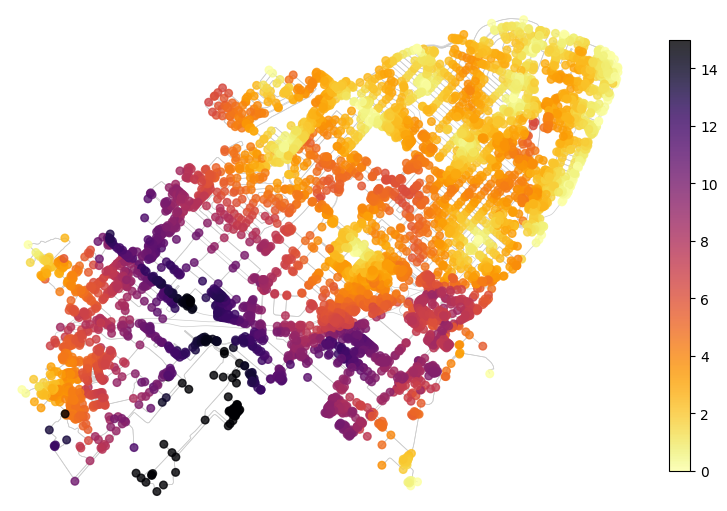

In [30]:
# example usage
plot_neighborhood_graph(transportation_type='biking',
                        neighbourhood='Saint-Laurent',
                        distances_by_transportation=biking_distances,
                        amenity='pharmacy')

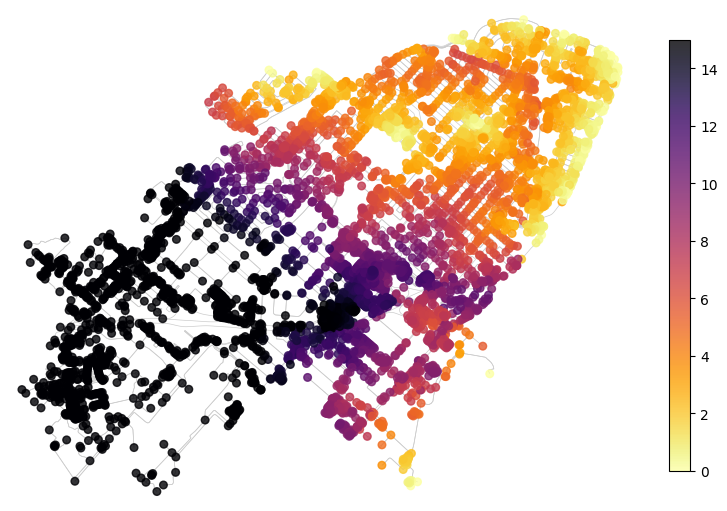

In [31]:
plot_neighborhood_graph(transportation_type='biking',
                        neighbourhood='Saint-Laurent', 
                        distances_by_transportation=biking_distances, 
                        amenity='hospital')

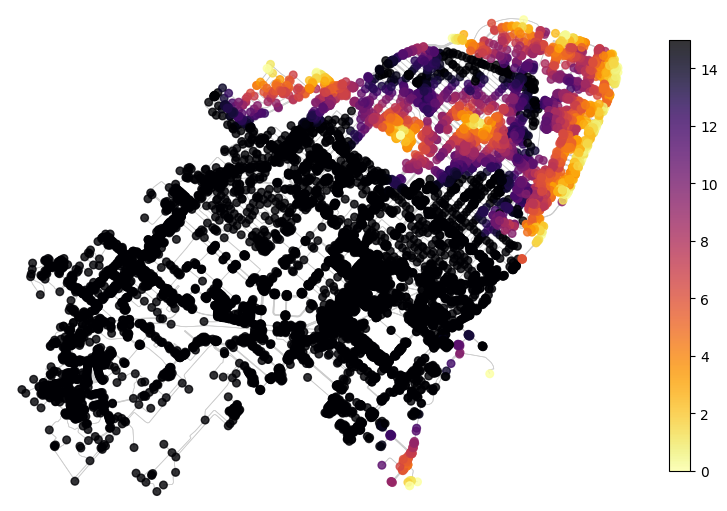

In [32]:
plot_neighborhood_graph(transportation_type='walking',
                        neighbourhood='Saint-Laurent', 
                        distances_by_transportation=walking_distances, 
                        amenity='hospital')

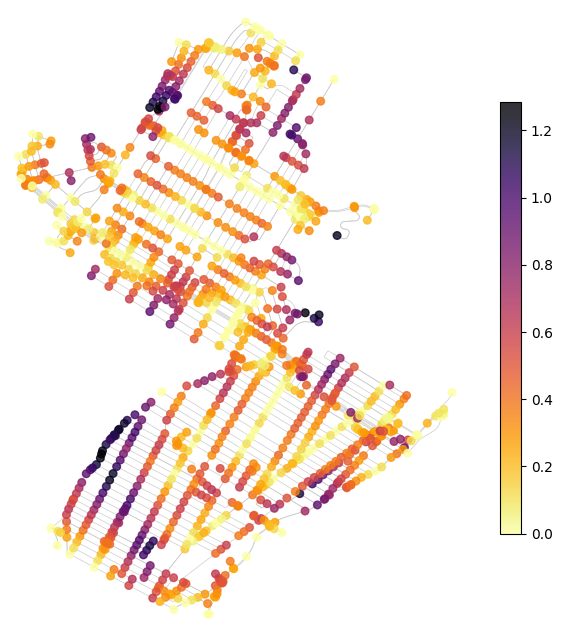

In [44]:
plot_neighborhood_graph(transportation_type='driving',
                        neighbourhood='Côte-des-Neiges–Notre-Dame-de-Grâce', 
                        distances_by_transportation=driving_distances, 
                        amenity='restaurant')

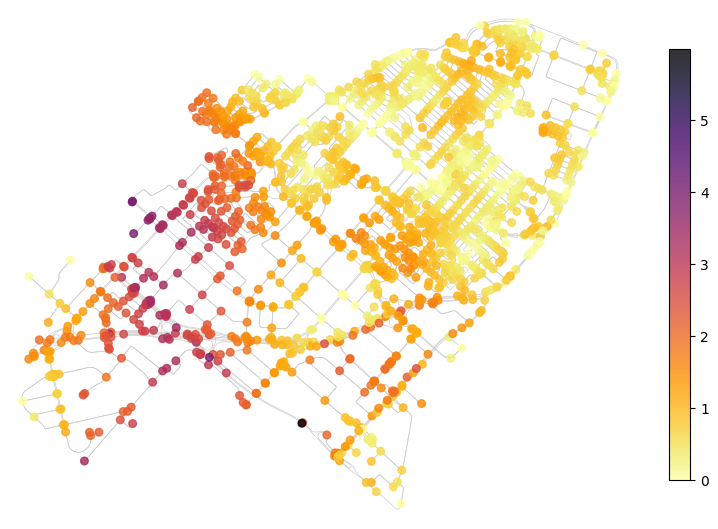

In [34]:
plot_neighborhood_graph(transportation_type='driving',
                        neighbourhood='Saint-Laurent', 
                        distances_by_transportation=driving_distances, 
                        amenity='restaurant')

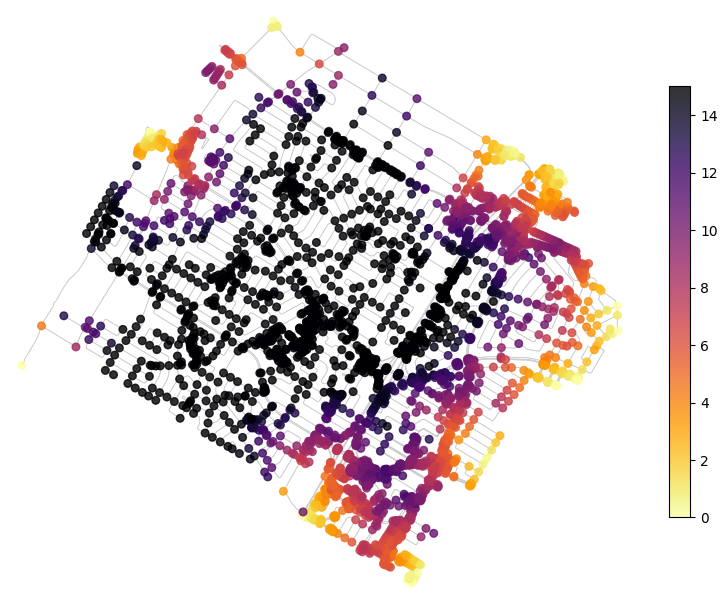

In [40]:
plot_neighborhood_graph(transportation_type='walking',
                        neighbourhood='Saint-Léonard', 
                        distances_by_transportation=walking_distances, 
                        amenity='hospital')

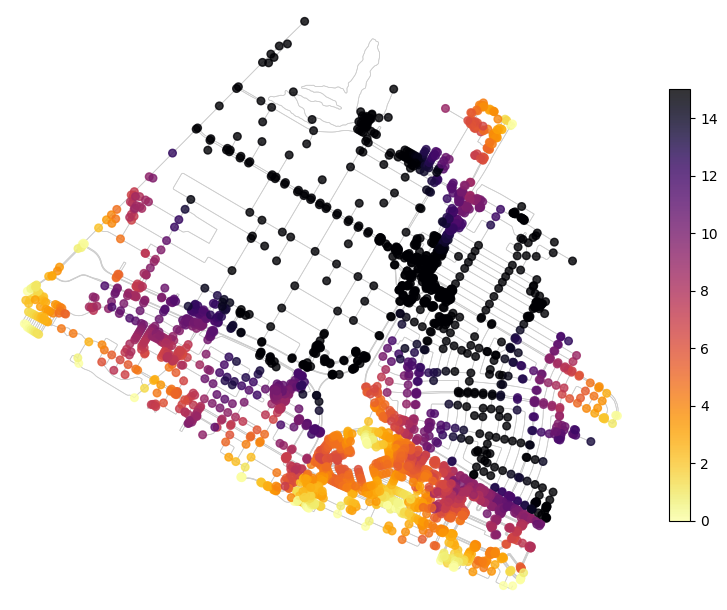

In [42]:
plot_neighborhood_graph(transportation_type='walking',
                        neighbourhood='Anjou', 
                        distances_by_transportation=walking_distances, 
                        amenity='restaurant')

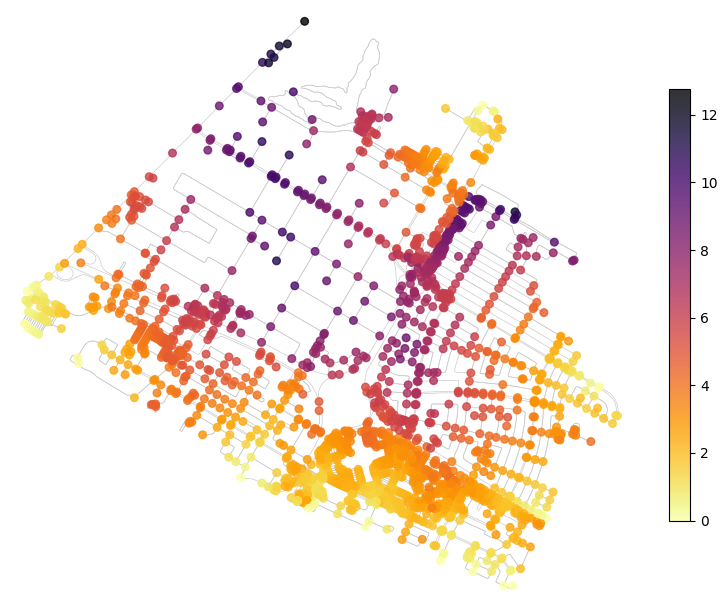

In [43]:
plot_neighborhood_graph(transportation_type='biking',
                        neighbourhood='Anjou', 
                        distances_by_transportation=biking_distances, 
                        amenity='hospital')

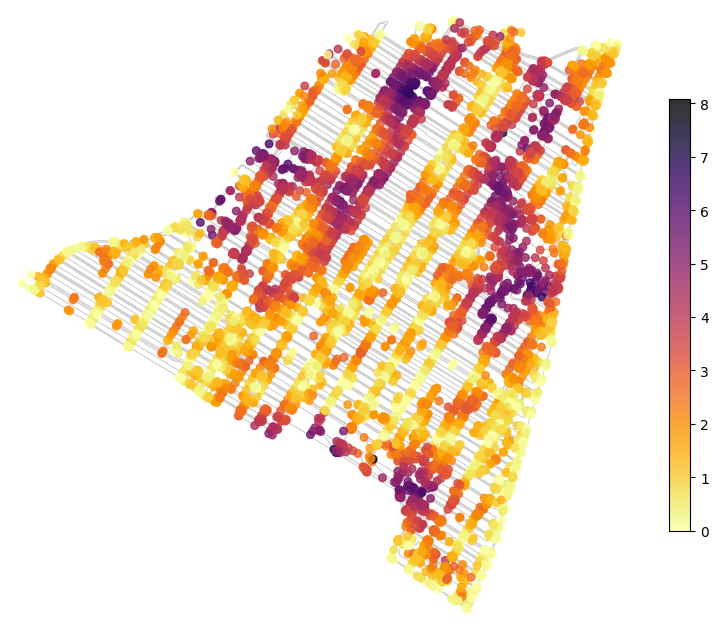

In [58]:
plot_neighborhood_graph(transportation_type='walking',
                        neighbourhood='Le Plateau-Mont-Royal', 
                        distances_by_transportation=walking_distances, 
                        amenity='cafe')